 <h1><center> <font color='green'>CNN-GAN
 
 </font></center></h1> 

 <h1><center> <font color='blue'>Librerías</font></center></h1>

In [1]:
import cv2
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, Conv2D, LeakyReLU, Flatten, Input, Activation
from tensorflow.keras.optimizers import Adam
from imageio import imread, imwrite

<h1><center> <font color='orange'>Carga y exploración de datos</font></center></h1> 

In [2]:
np.random.seed(5)

IMG_SHAPE = 128
batch_size = 32
random_seed = 9

In [3]:
'''Se especifican las direcciones de las carpetetas'''
dataset = r"C:\Users\Sebas\Documents\Tesis\DataSetEtiquetado"
ejemplos = r"C:\Users\Sebas\Documents\Tesis\DataSet_GANN"

In [4]:
def cargar_datos():
    dataset
    imagenes = os.listdir(dataset)
    n_imagenes = len(imagenes)
    x_train = np.empty((n_imagenes, 128, 128, 3), dtype=np.float32)
    
    for i, fname in enumerate(imagenes):
        if fname != '.DS_Store':
            imagen_path = os.path.join(dataset, fname)
            imagen = Image.open(imagen_path)
            imagen = imagen.resize((128, 128))  # Redimensionar la imagen a (128, 128)
            imagen = np.array(imagen)
            
            if imagen.shape[2] == 4:  # Si la imagen tiene 4 canales RGBA, convertir a 3 canales RGB
                imagen = imagen[:, :, :3]
            
            x_train[i, :] = (imagen - 127.5) / 127.5
            
    print('¡Listo!')
    return x_train


<h1><center> <font color='brow'>Definición del conjunto de datos de entrenamiento</font></center></h1>

In [5]:
def visualizar_imagen(nimagen, x_train):
    imagen = (x_train[nimagen, :] * 127.5) + 127.5
    imagen = np.ndarray.astype(imagen, np.uint8)
    plt.imshow(imagen.reshape(128, 128, 3))
    plt.axis('off')
    plt.show()

In [6]:
def graficar_imagenes_generadas(epoch, generador, ejemplos=16, dim=(4, 4), figsize=(10, 10)):
    ruido = np.random.normal(0, 1, [ejemplos, 100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(ejemplos, 128, 128, 3)
    imagenes_generadas = imagenes_generadas * 127.5 + 127.5
    plt.figure(figsize=figsize)
    for i in range(ejemplos):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(imagenes_generadas[i].astype('uint8'), interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('GAN_imagen_generada_%d.jpg' % epoch)
    plt.close()

In [7]:
def generar_imagenes(generador, nimagenes):
    ruido = np.random.normal(0, 1, [nimagenes, 100])
    imagenes_generadas = generador.predict(ruido)
    imagenes_generadas.reshape(nimagenes, 128, 128, 3)
    imagenes_generadas = imagenes_generadas * 127.5 + 127.5
    imagenes_generadas.astype('uint8')
    for i in range(nimagenes):
        imwrite(os.path.join(ejemplos, 'imagen_' + str(i) + '.jpg'), imagenes_generadas[i].reshape(128, 128, 3))


In [8]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
TAM_ENTRADA = 100
ERROR = 'binary_crossentropy'
LEAKY_SLOPE = 0.2
TAM_LOTE = 128
N_ITS = 6000

¡Listo!


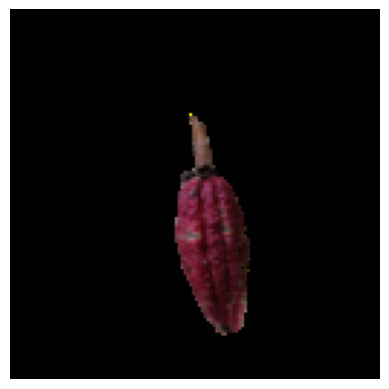

In [9]:
x_train = cargar_datos()
visualizar_imagen(250, x_train)


In [10]:
def crear_generador():
    modelo = Sequential()
    modelo.add(Dense(1024 * 4 * 4, use_bias=False, input_shape=(TAM_ENTRADA,)))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))
    modelo.add(Reshape((4, 4, 1024)))

    modelo.add(Conv2DTranspose(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(Activation('tanh'))

    modelo.compile(optimizer=optimizer, loss=ERROR)

    return modelo
generador = crear_generador()


 <h1><center> <font color='purple'>Implementación del modelo </font></center></h1> 

### GENERADOR GAN

In [11]:
def crear_discriminador():
    modelo = Sequential()
    modelo.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(128, 128, 3), use_bias=False))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(512, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Conv2D(1024, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(BatchNormalization(momentum=0.3))
    modelo.add(LeakyReLU(alpha=LEAKY_SLOPE))

    modelo.add(Flatten())
    modelo.add(Dense(1, activation='sigmoid', use_bias=False))

    modelo.compile(optimizer=optimizer, loss=ERROR)

    return modelo

discriminador = crear_discriminador()


### DISCRIMINADOR GAN

In [12]:
def crear_GAN(generador, discriminador):
    modelo = Sequential()
    modelo.add(generador)
    discriminador.trainable = False
    modelo.add(discriminador)
    modelo.compile(optimizer=optimizer, loss=ERROR)

    return modelo


### GAN

In [13]:
gan = crear_GAN(generador, discriminador)
gan.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 3)       19120576  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 17436864  
                                                                 
Total params: 36,557,440
Trainable params: 19,085,888
Non-trainable params: 17,471,552
_________________________________________________________________


# Entrenamiento del Modelo

In [15]:
gan.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy')

n_lotes = x_train.shape[0] // TAM_LOTE
for i in range(1, N_ITS + 1):
    print("Epoch " + str(i))

    ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
    batch_falsas = generador.predict(ruido)

    idx = np.random.randint(low=0, high=x_train.shape[0], size=TAM_LOTE)
    batch_reales = x_train[idx]

    discriminador.trainable = True

    dError_reales = discriminador.train_on_batch(batch_reales, np.ones(TAM_LOTE) * 0.9)
    dError_falsas = discriminador.train_on_batch(batch_falsas, np.zeros(TAM_LOTE) * 0.1)

    discriminador.trainable = False

    ruido = np.random.normal(0, 1, [TAM_LOTE, TAM_ENTRADA])
    gError = gan.train_on_batch(ruido, np.ones(TAM_LOTE))

    if i == 1 or i % 1000 == 0:
        graficar_imagenes_generadas(i, generador)
        generador.save('generador.h5')

generar_imagenes(generador, 200)

Epoch 1
1/1 [==============================] - 0s 409ms/step
Epoch 2
4/4 [==============================] - 2s 534ms/step
Epoch 3
4/4 [==============================] - 2s 539ms/step
Epoch 4
4/4 [==============================] - 2s 531ms/step
Epoch 5
4/4 [==============================] - 2s 529ms/step
Epoch 6
4/4 [==============================] - 2s 530ms/step
Epoch 7
4/4 [==============================] - 2s 531ms/step
Epoch 8
4/4 [==============================] - 2s 531ms/step
Epoch 9
4/4 [==============================] - 2s 533ms/step
Epoch 10
4/4 [==============================] - 2s 527ms/step
Epoch 11
4/4 [==============================] - 2s 527ms/step
Epoch 12
4/4 [==============================] - 2s 530ms/step
Epoch 13
4/4 [==============================] - 2s 530ms/step
Epoch 14
4/4 [==============================] - 2s 530ms/step
Epoch 15
4/4 [==============================] - 2s 528ms/step
Epoch 16
4/4 [==============================] - 2s 529ms/step
Epoch 17
4/4 [===

KeyboardInterrupt: 